# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x):
        # Место для вашего кода
         return tf.nn.sigmoid(tf.matmul(x, self.weights) + self.bias)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.hidden_layer_1 = DenseLayer(num_features, n_hidden_1, name='hidden_layer_1')

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.hidden_layer_2 = DenseLayer(n_hidden_1, n_hidden_2, name='hidden_layer_2')

    # Выходной слой
    # Место для вашего кода
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name='output_layer')
    # self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)
    # num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
    # n_hidden_2 = 256 # кількість нейронів 2-го шару

  def __call__(self, x):
    # Место для вашего кода
    # ...
    # Прямой проход через каждый слой с активационной функцией сигмоиды
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    # x = # Место для вашего кода
    # return tf.nn.softmax(x)
    # Применение функции softmax к выходу, чтобы получить вероятности классов
    x = tf.nn.softmax(self.output_layer(x))
    return x

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    # ...
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
optimizer = tf.optimizers.SGD(learning_rate)


@tf.function(reduce_retracing=True)
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  # optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
    # Место для вашего кода
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
steps_per_epoch = len(x_train) // batch_size
for step, (batch_x, batch_y) in enumerate(train_data.take(steps_per_epoch * training_steps), 1): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    loss = train(neural_net, batch_x, batch_y)
    loss_history.append(loss)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Место для вашего кода
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

Step: 695700, Loss: 378.4015197753906, Accuracy: 0.97265625
Step: 695800, Loss: 378.3956604003906, Accuracy: 0.984375
Step: 695900, Loss: 376.8571472167969, Accuracy: 0.9765625
Step: 696000, Loss: 378.42767333984375, Accuracy: 0.9765625
Step: 696100, Loss: 380.33233642578125, Accuracy: 0.97265625
Step: 696200, Loss: 376.5489196777344, Accuracy: 0.984375
Step: 696300, Loss: 378.21636962890625, Accuracy: 0.984375
Step: 696400, Loss: 376.9126281738281, Accuracy: 0.984375
Step: 696500, Loss: 376.0339660644531, Accuracy: 0.98828125
Step: 696600, Loss: 378.6389465332031, Accuracy: 0.97265625
Step: 696700, Loss: 376.7998962402344, Accuracy: 0.98046875
Step: 696800, Loss: 376.2947692871094, Accuracy: 0.98828125
Step: 696900, Loss: 377.96856689453125, Accuracy: 0.98046875
Step: 697000, Loss: 380.53887939453125, Accuracy: 0.9609375
Step: 697100, Loss: 377.65252685546875, Accuracy: 0.98046875
Step: 697200, Loss: 380.21588134765625, Accuracy: 0.96484375
Step: 697300, Loss: 375.3218078613281, Accur

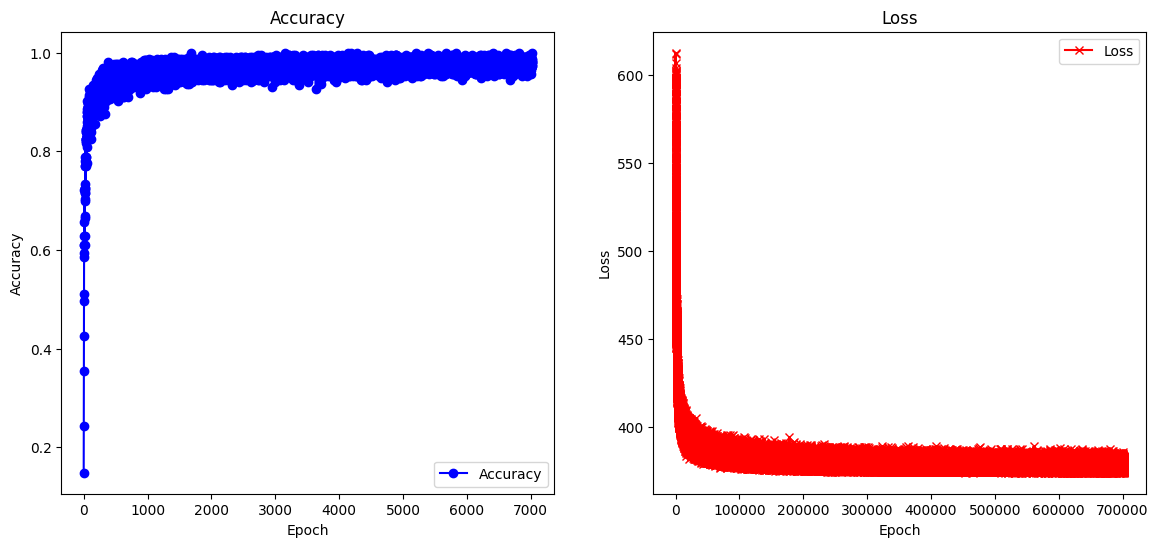

In [14]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
axes[0].plot(accuracy_history, label='Accuracy', color='b', marker='o')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(loss_history, label='Loss', color='r', marker='x')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_title('Loss')
axes[1].legend()

In [10]:
# Вычислите точность обученной нейросети

# Место для вашего кода
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Test Accuracy: {test_accuracy.numpy()}")

Test Accuracy: 0.9574000239372253


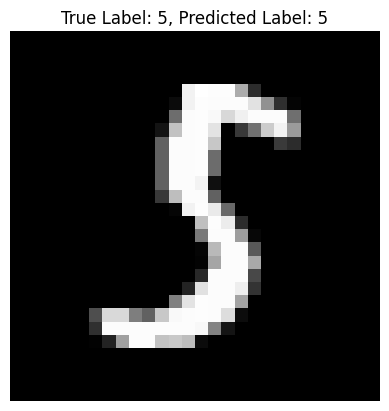

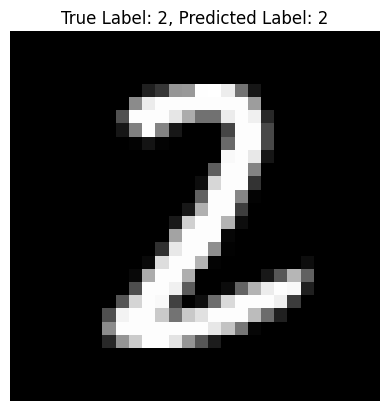

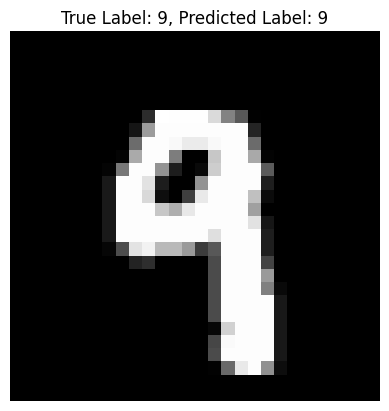

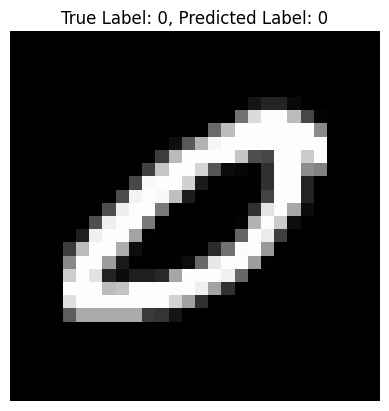

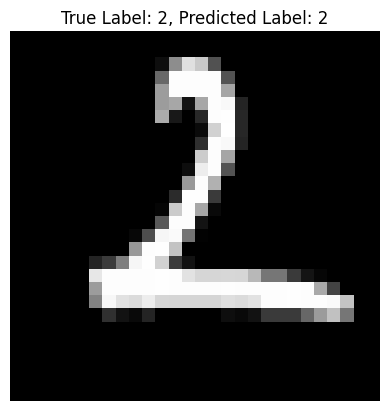

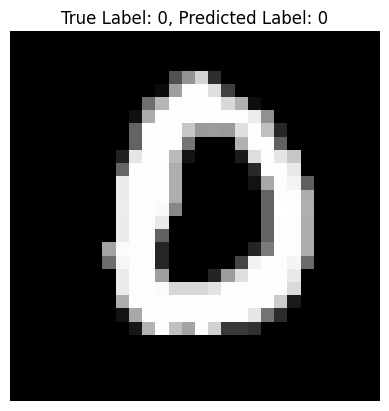

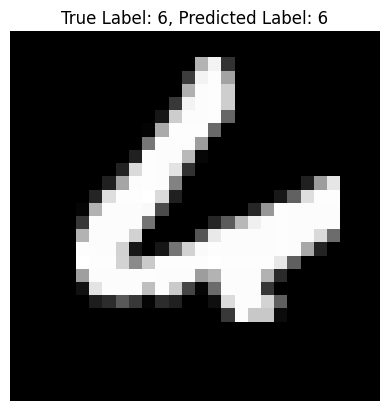

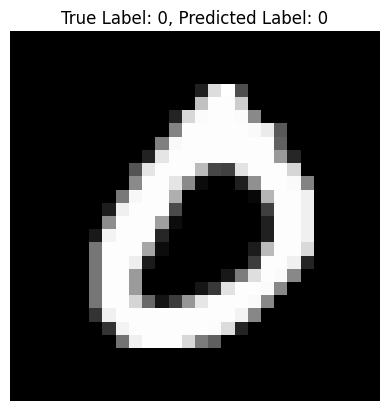

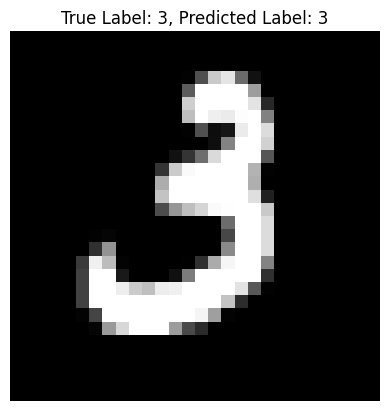

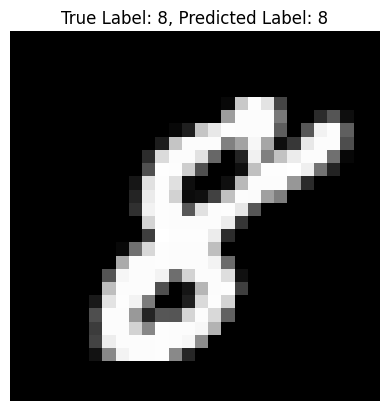

In [15]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
import random

random.seed(123)
indices = random.sample(range(len(x_test)), 10)

for index in indices:
    test_image = x_test[index]
    test_label = y_test[index]

    pred_probs = neural_net(tf.expand_dims(test_image, axis=0))
    pred_label = tf.argmax(pred_probs, axis=1).numpy()[0]

    plt.imshow(test_image.reshape(28, 28), cmap='gray')
    plt.title(f"True Label: {test_label}, Predicted Label: {pred_label}")
    plt.axis('off')
    plt.show()

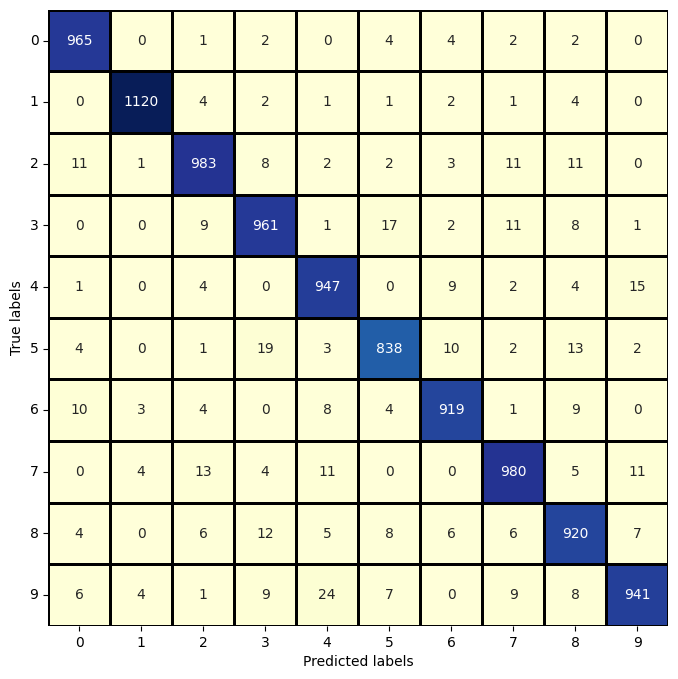

In [27]:
import random
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

random_choice = random.sample(range(len(x_test)), 10000)
test_images, test_values = x_test[random_choice], y_test[random_choice]

predict = neural_net(test_images)
predict_values = tf.argmax(predict, axis=1)

unique_labels = set(tf.make_ndarray(tf.make_tensor_proto(test_values)).flatten()) | set(tf.make_ndarray(tf.make_tensor_proto(predict_values)).flatten())
unique_labels = list(unique_labels)

cm = confusion_matrix(test_values, predict_values, labels=unique_labels)
df_confusion_matrix = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

plt.figure(figsize=(8, 8))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="YlGnBu", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.show()

# Висновок

Точність тестування нейромережі становить приблизно 95.74%. Це означає, що мережа вірно класифікує близько 95.74% тестових зображень, що є хорошим показником.

У цьому тесті було використано 10 рукописних зображень цифр для перевірки роботи нейромережі. З цих 10 зображень усі 10 були правильно визначені. Це говорить про те, що в цьому конкретному тестовому наборі нейромережа показала високу ефективність і точність.

Однак варто зазначити, що результати тестування не завжди повністю відображають роботу нейромережі в реальних умовах. Застосування нейромережі до нових, раніше не бачених даних може призвести до інших результатів, і точність може відрізнятися залежно від складності та різноманітності тестового набору.

Матриця помилок дає змогу наочно побачити, які класи (цифри) було правильно визначено, а які було неправильно класифіковано. Основна діагональ матриці являє собою правильні передбачення, а значення поза діагоналлю вказують на помилки класифікації. Що темніший колір клітинки на тепловій карті, то менше помилок класифікації між відповідними класами. Що світліший колір клітинки, то більше помилок.

Нейромережа найгірше визначає цифру 5, а найкраще цифру 1. Найчастіше плутає 4 з 9 (24) та 3 з 5 (19).

Загалом нейромережа, здатна правильно визначати рукописні цифри з точністю понад 95%, може бути корисною в різних додатках, як-от системи оптичного розпізнавання символів (OCR), системи класифікації почерку та інші завдання, пов'язані з опрацюванням рукописних даних.